Steps:
1. for pickled networks split into communities 
3. plot distribiution of comminities 
2. do a set of largest communities 
3. for all communities in a set
    4. for each community get cosine similarity of random hashtags (1000)
    5. for each community plot distribution of cosine similarity 
    + check if one hashtag is appearing a larger amount of times than the otehrs
4. summarise all community plots - distribution of all distributions 
5. plot overlap of distibutions between networks 


In [4]:
from sentence_transformers import SentenceTransformer
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import community as community_louvain  # Louvain algorithm
import matplotlib.pyplot as plt
import community as community_louvain
from collections import defaultdict
import pandas as pd
import pickle
import igraph as ig
import leidenalg

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
network_files = {
    "cooccurrence": "../ready_networks/cooc_filtered.pkl",
    "likes": "../ready_networks/likes_network.pkl",
    "follower": "../ready_networks/follow_filtered.pkl",
    "duet_stitch": "../ready_networks/ds_network.pkl"
}
networks = {name: pickle.load(open(path, 'rb')) for name, path in network_files.items()}

In [12]:
def nx_to_igraph(G):
    G = G.copy()
    is_directed = nx.is_directed(G)

    # Create igraph Graph
    ig_graph = ig.Graph(directed=is_directed)

    # Add nodes
    ig_graph.add_vertices(list(G.nodes))

    # Add edges
    ig_graph.add_edges(list(G.edges))

    # Optional: Transfer weights if they exist
    if nx.get_edge_attributes(G, 'weight'):
        ig_graph.es['weight'] = [G[u][v].get('weight', 1.0) for u, v in G.edges]

    return ig_graph


In [13]:
for name, nx_graph in networks.items():
    ig_graph = nx_to_igraph(nx_graph)
    partition = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)
    communities[name] = partition
    print(f"{name}: {len(partition)} communities detected.")

cooccurrence: 574 communities detected.
likes: 14 communities detected.
follower: 22 communities detected.
duet_stitch: 23 communities detected.


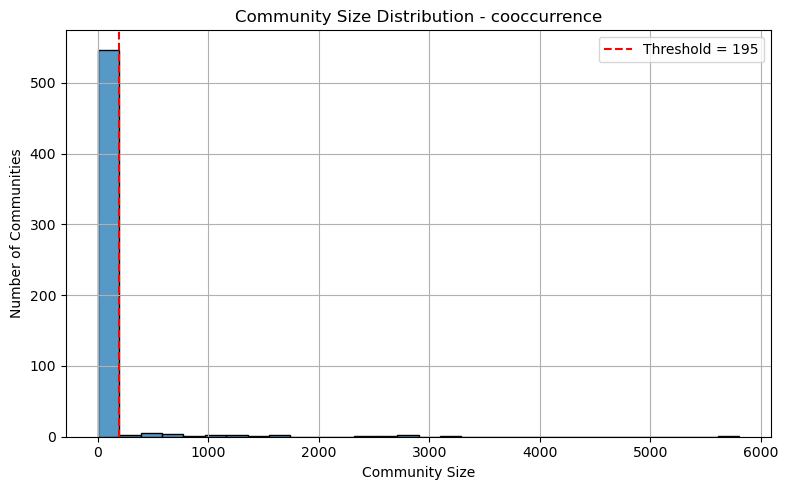

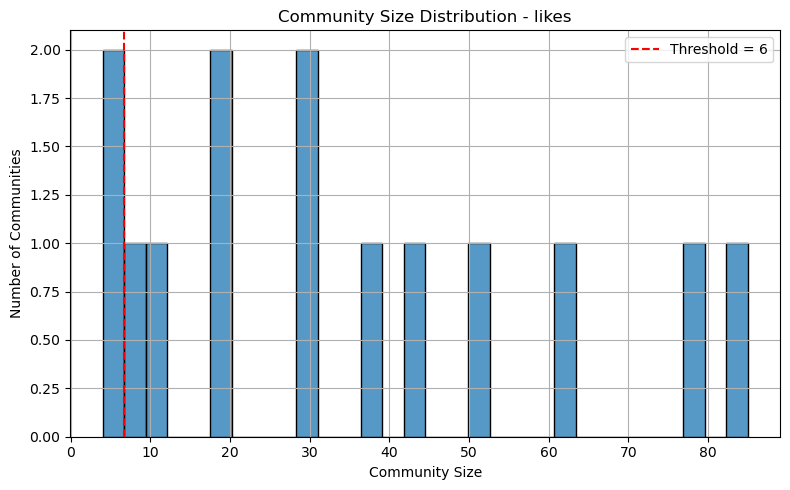

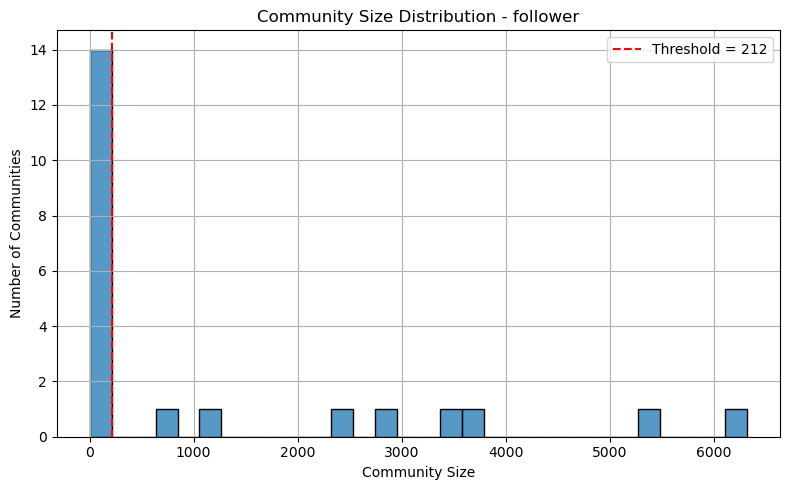

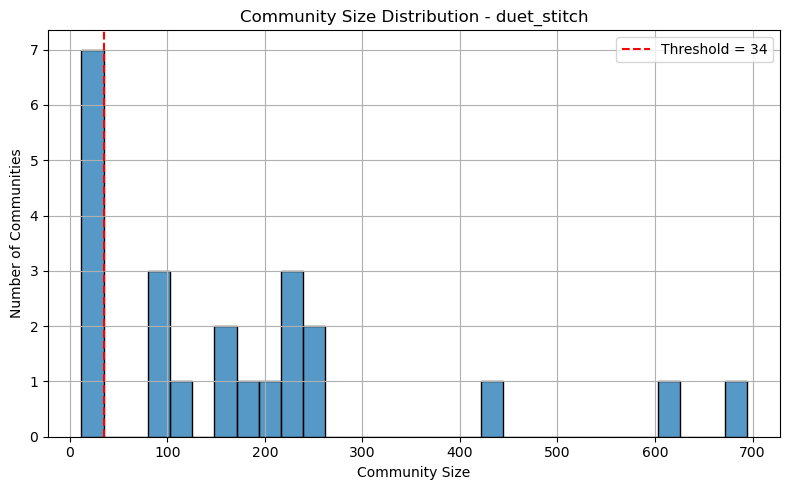

Thresholds and large community counts by network:
cooccurrence: threshold = 195, communities ≥ threshold = 27
likes: threshold = 6, communities ≥ threshold = 12
follower: threshold = 212, communities ≥ threshold = 8
duet_stitch: threshold = 34, communities ≥ threshold = 16


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Store thresholds and counts
thresholds = {}
large_community_counts = {}

for name, partition in communities.items():
    community_sizes = [len(c) for c in partition]

    # Create histogram data
    counts, bins = np.histogram(community_sizes, bins=30)
    max_bin_index = np.argmax(counts)

    # Set threshold after largest bin
    threshold = bins[max_bin_index + 1]
    thresholds[name] = threshold

    # Count communities larger than the threshold
    large_communities = [size for size in community_sizes if size >= threshold]
    large_community_counts[name] = len(large_communities)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.histplot(community_sizes, bins=30, kde=False)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {int(threshold)}')
    plt.title(f"Community Size Distribution - {name}")
    plt.xlabel("Community Size")
    plt.ylabel("Number of Communities")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print summary
print("Thresholds and large community counts by network:")
for name in communities:
    print(f"{name}: threshold = {int(thresholds[name])}, communities ≥ threshold = {large_community_counts[name]}")


In [32]:
# Step 1: Get the Leiden partition for the cooccurrence network
partition = communities["cooccurrence"]  # This is an igraph Clustering object (list-like)

# Step 2: Sort communities by size (descending)
sorted_partition = sorted(partition, key=lambda c: len(c), reverse=True)

# Step 3: Take top 27 largest communities
top_27_communities = sorted_partition[:27]

# Step 4: Get the node IDs in those communities (from igraph, so integer indices)
nodes_to_keep = set(chain.from_iterable(top_27_communities))

# Step 5: Get the original NetworkX graph
nx_graph = networks["cooccurrence"]

# Step 6: Map igraph node indices back to NetworkX node labels
# The igraph nodes preserve the original NetworkX node labels in the "name" attribute
ig_graph = nx_to_igraph(nx_graph)
index_to_node = {idx: ig_graph.vs[idx]["name"] for idx in nodes_to_keep}
nodes_to_keep_nx = set(index_to_node.values())

# Step 7: Filter the NetworkX graph to keep only those nodes
filtered_graph = nx_graph.subgraph(nodes_to_keep_nx).copy()

# Optional: Save or overwrite in your networks dictionary
networks["cooccurrence_top27"] = filtered_graph

# Summary
print(f"Filtered cooccurrence graph (top 27 communities):")
print(f"Nodes: {filtered_graph.number_of_nodes()}, Edges: {filtered_graph.number_of_edges()}")


Filtered cooccurrence graph (top 27 communities):
Nodes: 38002, Edges: 433308
